# Text Mining Final project


## Required Packages

In [207]:
import pandas as pd
import os
import scipy
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import pearsonr

## Importing data

In [208]:
# Change working directory
cwd = r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\final_project"
os.chdir(cwd)

In [209]:
# Import CSV file
df = pd.read_csv("lyrics_output.csv", encoding='utf-8',encoding_errors='ignore')

# Display the first few rows
df

,year,ranking,title,artist,lyrics
0,1981,1,Bette Davis Eyes,Kim Carnes,[Verse 1]\nHer hair is Harlow gold\nHer lips s...
1,1981,2,Endless Love,Diana Ross & Lionel Richie,[Verse 1: Lionel Richie & Diana Ross]\nMy love...
2,1981,3,Lady,Kenny Rogers,[Verse 1]\nLady\nI'm your knight in shining ar...
3,1981,4,(Just Like) Starting Over,John Lennon,NaN
4,1981,5,Jessie's Girl,Rick Springfield,"[Verse 1]\nJessie is a friend\nYeah, I know, h..."
...,...,...,...,...,...
4077,2021,96,Things a Man Oughta Know,Lainey Wilson,[Verse 1]\nI can hook a trailer on a two-inch ...
4078,2021,97,Throat Baby (Go Baby),BRS Kash,"[Intro]\n(What's happenin', Chi Chi?)\n[Chorus..."
4079,2021,98,Tombstone,Rod Wave,"[Intro]\nDamn, this motherfucker too crazy, Sa..."
4080,2021,99,Drinkin' Beer. Talkin' God. Amen.,Chase Rice featuring Florida Georgia Line,[Verse 1: Chase Rice]\nFirewood crackle in the...


In [210]:
# Dropping missing in df
# Drop rows with missing values
df.dropna(inplace=True)

## Preprocessing text and Wordcloud

In [211]:
# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [212]:

def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing punctuation and stopwords using spaCy's token attributes.
       - Lemmatizing the text.
       - (Note: This function does NOT lowercase the text.)
    
    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """
    doc = sp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']
    return " ".join(lemmatized_tokens)

def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

In [213]:
corpus_data = df.copy()

In [214]:
corpus_data

,year,ranking,title,artist,lyrics
0,1981,1,Bette Davis Eyes,Kim Carnes,[Verse 1]\nHer hair is Harlow gold\nHer lips s...
1,1981,2,Endless Love,Diana Ross & Lionel Richie,[Verse 1: Lionel Richie & Diana Ross]\nMy love...
2,1981,3,Lady,Kenny Rogers,[Verse 1]\nLady\nI'm your knight in shining ar...
4,1981,5,Jessie's Girl,Rick Springfield,"[Verse 1]\nJessie is a friend\nYeah, I know, h..."
5,1981,6,Celebration,Kool & the Gang,[Intro]\nYahoo! (This is your celebration)\nYa...
...,...,...,...,...,...
4077,2021,96,Things a Man Oughta Know,Lainey Wilson,[Verse 1]\nI can hook a trailer on a two-inch ...
4078,2021,97,Throat Baby (Go Baby),BRS Kash,"[Intro]\n(What's happenin', Chi Chi?)\n[Chorus..."
4079,2021,98,Tombstone,Rod Wave,"[Intro]\nDamn, this motherfucker too crazy, Sa..."
4080,2021,99,Drinkin' Beer. Talkin' God. Amen.,Chase Rice featuring Florida Georgia Line,[Verse 1: Chase Rice]\nFirewood crackle in the...


In [215]:
mod = 2

# Pre-process the text column with progress tracking
try:
    corpus_data["text_preproc"] = corpus_data.lyrics.astype(str).progress_apply(lambda row: tokenize(row, mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)

100%|██████████| 3821/3821 [01:27<00:00, 43.63it/s]

Done processing text.


In [216]:
mod = 0

# Pre-process the text column with progress tracking
try:
    corpus_data["text_preproc"] = corpus_data.text_preproc.astype(str).progress_apply(lambda row: tokenize(row, mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)

100%|██████████| 3821/3821 [00:00<00:00, 6679.10it/s]

Done processing text.


In [217]:
corpus_data

,year,ranking,title,artist,lyrics,text_preproc
0,1981,1,Bette Davis Eyes,Kim Carnes,[Verse 1]\nHer hair is Harlow gold\nHer lips s...,verse 1 hair harlow gold lip sweet surprise ha...
1,1981,2,Endless Love,Diana Ross & Lionel Richie,[Verse 1: Lionel Richie & Diana Ross]\nMy love...,verse 1 lionel richie diana ross love life thi...
2,1981,3,Lady,Kenny Rogers,[Verse 1]\nLady\nI'm your knight in shining ar...,verse 1 lady knight shine armor love love way ...
4,1981,5,Jessie's Girl,Rick Springfield,"[Verse 1]\nJessie is a friend\nYeah, I know, h...",verse 1 jessie friend yeah know good friend la...
5,1981,6,Celebration,Kool & the Gang,[Intro]\nYahoo! (This is your celebration)\nYa...,intro yahoo celebration yahoo celebration cele...
...,...,...,...,...,...,...
4077,2021,96,Things a Man Oughta Know,Lainey Wilson,[Verse 1]\nI can hook a trailer on a two-inch ...,verse 1 hook trailer inch hitch shoot shotgun ...
4078,2021,97,Throat Baby (Go Baby),BRS Kash,"[Intro]\n(What's happenin', Chi Chi?)\n[Chorus...",intro happenin chi chi chorus sexy lil bitch s...
4079,2021,98,Tombstone,Rod Wave,"[Intro]\nDamn, this motherfucker too crazy, Sa...",intro damn motherfucker crazy saucii let shit ...
4080,2021,99,Drinkin' Beer. Talkin' God. Amen.,Chase Rice featuring Florida Georgia Line,[Verse 1: Chase Rice]\nFirewood crackle in the...,verse 1 chase rice firewood crackle fall air r...


In [239]:
# Define custom stopwords (case-insensitive)
custom_stopwords_list = ["verse", "chorus", "prechorus", "dont", "na", "im", "youre", "ive", "la", "oh", "da", "ta", 
                         "ayy", "ah", "ohoh", "yeah", "m", "s", "1", "2", "ooh", "doo", "know", "woah", "ha", "wop", "duh",
                         "ooo","dey", "sa", "woo", "ugh", "ho", "ou", "ud", "de", "eh", "mmm", "ba", "yo", "hey", "ay", "ya",] 
custom_stopwords = set(STOPWORDS).union(set(word.lower() for word in custom_stopwords_list))

# Convert text_preproc column to lowercase
corpus_data['text_preproc'] = corpus_data['text_preproc'].str.lower()

# **Step 1: Remove stopwords from the entire corpus before generating word clouds**
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in custom_stopwords]
    return " ".join(filtered_words)

# Apply stopword removal to the entire column
corpus_data['text_preproc'] = corpus_data['text_preproc'].apply(remove_stopwords)

In [241]:
# from collections import Counter
# # Get unique years in the dataset
# years = sorted(corpus_data['year'].unique())

# # **Step 2: Generate word clouds**
# for year in years:
#     # Filter dataset for the specific year
#     df_year = corpus_data[corpus_data['year'] == year]

#     # Combine all preprocessed text into a single string
#     text = " ".join(df_year['text_preproc'])

#     # Count word frequencies
#     word_freq = Counter(text.split())

#     # Generate word cloud using raw word frequencies
#     wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

#     # Display the word cloud with the year as title
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(f"Word Cloud for Year {year}", fontsize=14)
#     plt.show()


## LDA Pipeline

In [242]:
corpus_data

,year,ranking,title,artist,lyrics,text_preproc
0,1981,1,Bette Davis Eyes,Kim Carnes,[Verse 1]\nHer hair is Harlow gold\nHer lips s...,hair harlow gold lip sweet surprise hand cold ...
1,1981,2,Endless Love,Diana Ross & Lionel Richie,[Verse 1: Lionel Richie & Diana Ross]\nMy love...,lionel richie diana ross love life thing right...
2,1981,3,Lady,Kenny Rogers,[Verse 1]\nLady\nI'm your knight in shining ar...,lady knight shine armor love love way want lov...
4,1981,5,Jessie's Girl,Rick Springfield,"[Verse 1]\nJessie is a friend\nYeah, I know, h...",jessie friend good friend lately change hard d...
5,1981,6,Celebration,Kool & the Gang,[Intro]\nYahoo! (This is your celebration)\nYa...,intro yahoo celebration yahoo celebration cele...
...,...,...,...,...,...,...
4077,2021,96,Things a Man Oughta Know,Lainey Wilson,[Verse 1]\nI can hook a trailer on a two-inch ...,hook trailer inch hitch shoot shotgun catch fi...
4078,2021,97,Throat Baby (Go Baby),BRS Kash,"[Intro]\n(What's happenin', Chi Chi?)\n[Chorus...",intro happenin chi chi sexy lil bitch sexy lil...
4079,2021,98,Tombstone,Rod Wave,"[Intro]\nDamn, this motherfucker too crazy, Sa...",intro damn motherfucker crazy saucii let shit ...
4080,2021,99,Drinkin' Beer. Talkin' God. Amen.,Chase Rice featuring Florida Georgia Line,[Verse 1: Chase Rice]\nFirewood crackle in the...,chase rice firewood crackle fall air red dirt ...


In [243]:
# Creating DTM
cv = CountVectorizer(ngram_range = (1,1), lowercase=False, max_df=0.9)
cv.fit(corpus_data.text_preproc)
vectorized_text=cv.transform(corpus_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (3821, 13407)


In [244]:
# Using Gensim LDA
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(vectorized_text)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

# Number of topics
num_topics = 10

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=50)
for topic in topics:
    print(topic)
    print("    ")

# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

print(corpus_data.text_preproc[10])
print("  ")
#this produces a lits of tuples
print(doc_topics[10])

topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)


(0, '0.031*"let" + 0.023*"go" + 0.018*"dance" + 0.018*"come" + 0.017*"tonight" + 0.011*"low" + 0.011*"want" + 0.010*"night" + 0.009*"girl" + 0.009*"good" + 0.009*"right" + 0.008*"turn" + 0.008*"cause" + 0.007*"party" + 0.007*"pre" + 0.007*"floor" + 0.006*"intro" + 0.006*"justin" + 0.006*"fire" + 0.006*"wan" + 0.006*"sexy" + 0.006*"hand" + 0.006*"love" + 0.005*"di" + 0.005*"music" + 0.005*"light" + 0.005*"young" + 0.005*"stop" + 0.005*"man" + 0.004*"head" + 0.004*"little" + 0.004*"roll" + 0.004*"everybody" + 0.004*"feel" + 0.004*"body" + 0.004*"thoia" + 0.004*"way" + 0.004*"shot" + 0.004*"ready" + 0.004*"start" + 0.004*"time" + 0.003*"break" + 0.003*"baby" + 0.003*"look" + 0.003*"well" + 0.003*"burn" + 0.003*"timberlake" + 0.003*"mi" + 0.003*"dem" + 0.003*"rock"')
    
(1, '0.023*"bitch" + 0.022*"shit" + 0.018*"fuck" + 0.017*"nigga" + 0.012*"niggas" + 0.012*"bad" + 0.009*"intro" + 0.009*"cause" + 0.008*"girl" + 0.008*"boy" + 0.007*"real" + 0.007*"wan" + 0.006*"ass" + 0.006*"money" + 0.0

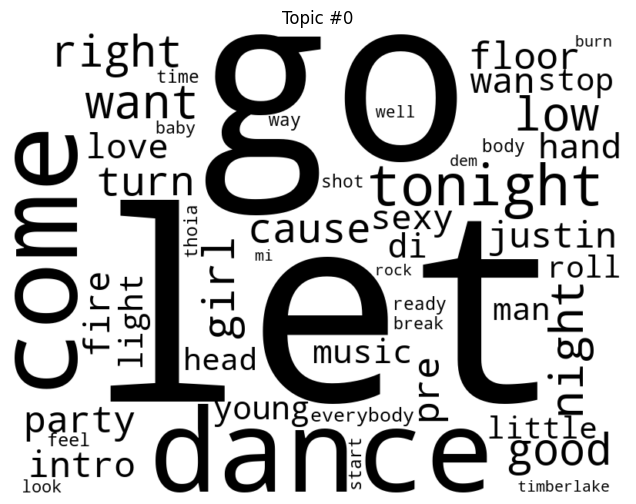

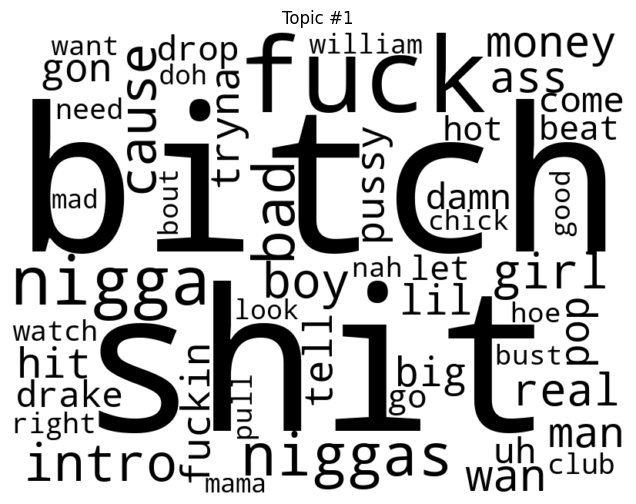

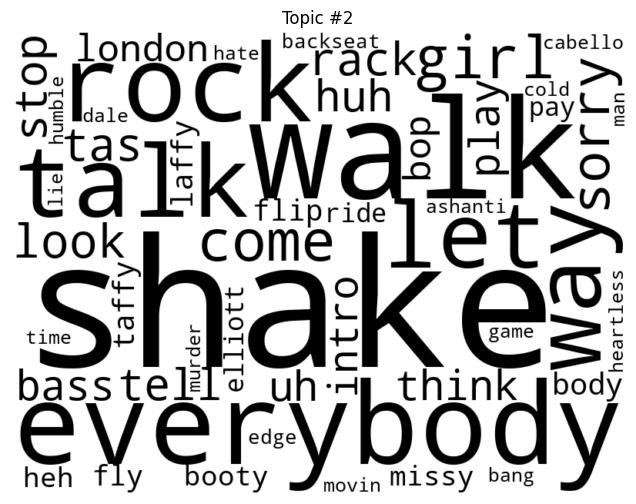

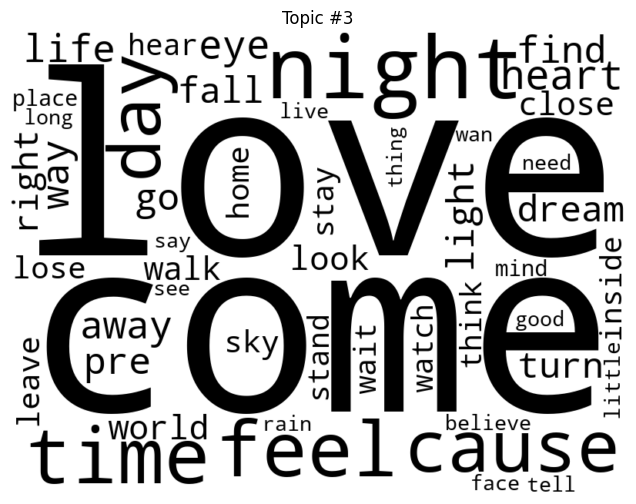

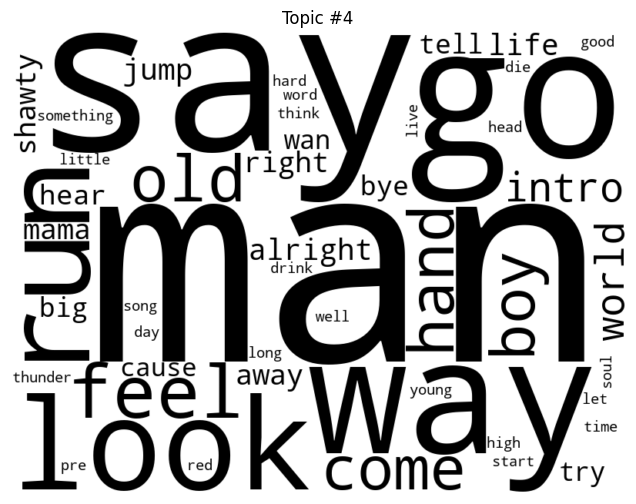

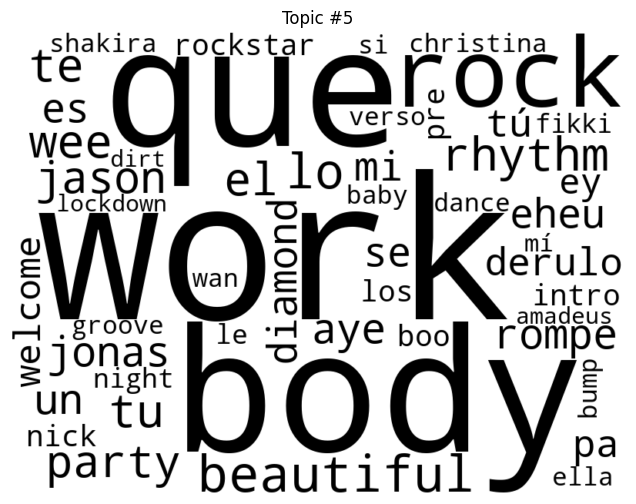

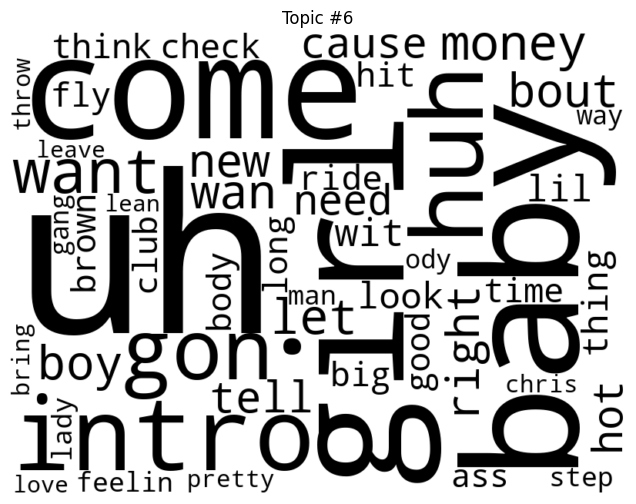

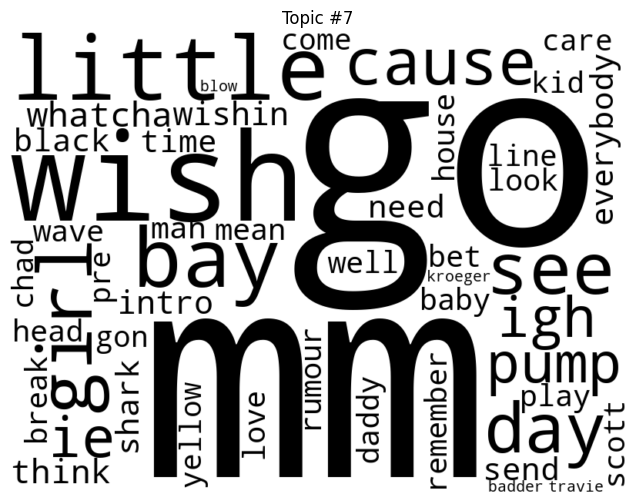

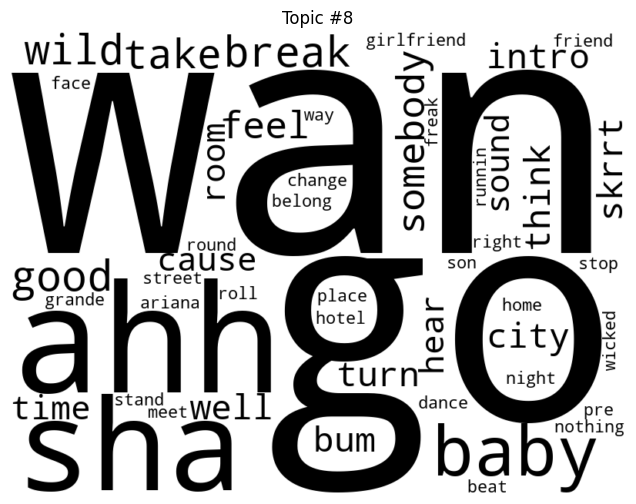

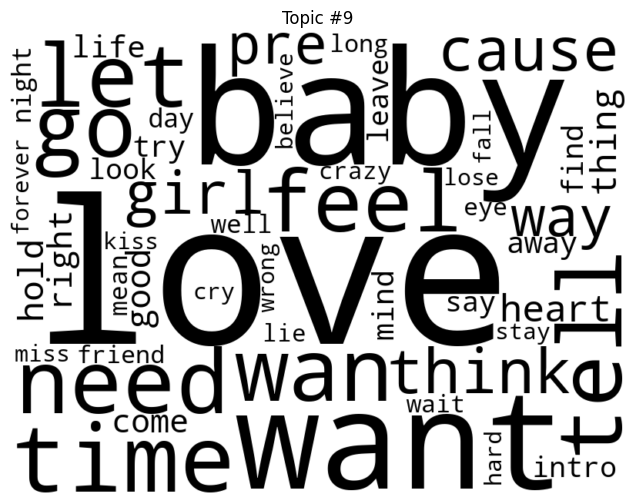

In [245]:
from wordcloud import WordCloud

def generate_wordclouds(topics, dictionary):
    for topic_num, topic_words in topics:
        word_freq = dict(topic_words)
        wordcloud = WordCloud(
            width = 800,
            height = 600,
            background_color ='white',
            color_func=lambda *args, **kwargs: "black", # Ensures words are in black
            min_font_size = 10).generate_from_frequencies(word_freq)
        
        plt.figure(figsize = (8, 6), facecolor = None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Topic #{topic_num}')
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(topics, lda_model.id2word)
